# Premier League / FPL Analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
players = pd.read_csv('C:\\Users\\Ryan\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2019-20\\cleaned_players.csv')

In [3]:
players_us = pd.read_csv('C:\\Users\\Ryan\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2019-20\\understat_player.csv', encoding='latin')

In [4]:
def drop_y(df):
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

In [5]:
players.insert(2,'full_name', players['first_name'] + ' ' + players['second_name'])

In [6]:
player_stats = pd.merge(players, players_us, left_on='full_name', right_on='player_name', suffixes=('','_y'))

In [7]:
player_stats.shape

(353, 37)

In [8]:
drop_y(player_stats)

In [9]:
player_stats.shape

(353, 34)

In [10]:
player_stats.sort_values('total_points', ascending=False, inplace=True)

In [11]:
player_stats.head(10)

,first_name,second_name,full_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,...,npxG,player_name,position,shots,team_title,time,xA,xG,xGBuildup,xGChain
140,Jamie,Vardy,Jamie Vardy,9,2,74,900,8,79.2,343.6,...,3.520233,Jamie Vardy,F,20,Leicester,900,0.768060,4.281402,0.250875,4.539169
177,Kevin,De Bruyne,Kevin De Bruyne,2,10,72,693,4,539.8,342.0,...,2.552342,Kevin De Bruyne,M S,22,Manchester City,708,5.976346,2.552342,7.715962,13.685913
176,Raheem,Sterling,Raheem Sterling,7,1,64,790,9,277.9,335.0,...,6.653559,Raheem Sterling,F M,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886
161,Sadio,Mané,Sadio Mané,5,3,64,786,6,243.5,273.4,...,3.797911,Sadio Mané,F S,21,Liverpool,792,1.693457,3.797911,1.510550,6.290631
175,Sergio,Agüero,Sergio Agüero,8,3,62,574,8,136.0,319.6,...,5.267427,Sergio Agüero,F S,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234
160,Mohamed,Salah,Mohamed Salah,5,3,62,792,6,229.9,285.6,...,4.597042,Mohamed Salah,F,33,Liverpool,799,1.452970,6.119380,3.244458,8.333571
94,Tammy,Abraham,Tammy Abraham,8,1,61,728,10,127.9,319.0,...,5.650421,Tammy Abraham,F S,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866
179,David,Silva,David Silva,3,5,60,650,4,213.4,240.4,...,3.285382,David Silva,M S,15,Manchester City,660,2.579371,3.285382,5.166738,10.055790
3,Pierre-Emerick,Aubameyang,Pierre-Emerick Aubameyang,7,1,59,900,14,136.7,286.0,...,4.599651,Pierre-Emerick Aubameyang,F M,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725
230,Teemu,Pukki,Teemu Pukki,6,2,57,885,24,138.9,280.4,...,3.920436,Teemu Pukki,F,28,Norwich,892,2.549643,3.920436,0.399120,6.754207


In [12]:
player_stats.columns

Index(['first_name', 'second_name', 'full_name', 'goals_scored', 'assists',
       'total_points', 'minutes', 'goals_conceded', 'creativity', 'influence',
       'threat', 'bonus', 'bps', 'ict_index', 'clean_sheets', 'red_cards',
       'yellow_cards', 'selected_by_percent', 'now_cost', 'games', 'goals',
       'id', 'key_passes', 'npg', 'npxG', 'player_name', 'position', 'shots',
       'team_title', 'time', 'xA', 'xG', 'xGBuildup', 'xGChain'],
      dtype='object')

In [13]:
player_stats.drop(['first_name', 'second_name'], axis=1,inplace=True)

In [14]:
player_stats.shape

(353, 32)

In [15]:
player_stats.head(10)

,full_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,...,npxG,player_name,position,shots,team_title,time,xA,xG,xGBuildup,xGChain
140,Jamie Vardy,9,2,74,900,8,79.2,343.6,323.0,13,...,3.520233,Jamie Vardy,F,20,Leicester,900,0.768060,4.281402,0.250875,4.539169
177,Kevin De Bruyne,2,10,72,693,4,539.8,342.0,199.0,10,...,2.552342,Kevin De Bruyne,M S,22,Manchester City,708,5.976346,2.552342,7.715962,13.685913
176,Raheem Sterling,7,1,64,790,9,277.9,335.0,610.0,7,...,6.653559,Raheem Sterling,F M,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886
161,Sadio Mané,5,3,64,786,6,243.5,273.4,286.0,8,...,3.797911,Sadio Mané,F S,21,Liverpool,792,1.693457,3.797911,1.510550,6.290631
175,Sergio Agüero,8,3,62,574,8,136.0,319.6,392.0,6,...,5.267427,Sergio Agüero,F S,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234
160,Mohamed Salah,5,3,62,792,6,229.9,285.6,557.0,7,...,4.597042,Mohamed Salah,F,33,Liverpool,799,1.452970,6.119380,3.244458,8.333571
94,Tammy Abraham,8,1,61,728,10,127.9,319.0,400.0,11,...,5.650421,Tammy Abraham,F S,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866
179,David Silva,3,5,60,650,4,213.4,240.4,297.0,7,...,3.285382,David Silva,M S,15,Manchester City,660,2.579371,3.285382,5.166738,10.055790
3,Pierre-Emerick Aubameyang,7,1,59,900,14,136.7,286.0,403.0,10,...,4.599651,Pierre-Emerick Aubameyang,F M,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725
230,Teemu Pukki,6,2,57,885,24,138.9,280.4,439.0,9,...,3.920436,Teemu Pukki,F,28,Norwich,892,2.549643,3.920436,0.399120,6.754207


In [16]:
player_stats.columns

Index(['full_name', 'goals_scored', 'assists', 'total_points', 'minutes',
       'goals_conceded', 'creativity', 'influence', 'threat', 'bonus', 'bps',
       'ict_index', 'clean_sheets', 'red_cards', 'yellow_cards',
       'selected_by_percent', 'now_cost', 'games', 'goals', 'id', 'key_passes',
       'npg', 'npxG', 'player_name', 'position', 'shots', 'team_title', 'time',
       'xA', 'xG', 'xGBuildup', 'xGChain'],
      dtype='object')

In [17]:
player_stats.loc[146]

full_name              Wilfred Ndidi
goals_scored                       2
assists                            0
total_points                      33
minutes                          810
goals_conceded                     7
creativity                      83.7
influence                      246.4
threat                            64
bonus                              3
bps                              162
ict_index                       39.6
clean_sheets                       3
red_cards                          0
yellow_cards                       1
selected_by_percent              3.2
now_cost                          50
games                              9
goals                              2
id                              5545
key_passes                         5
npg                                2
npxG                        0.523585
player_name            Wilfred Ndidi
position                           M
shots                              7
team_title                 Leicester
t

In [18]:

player_stats.reset_index(drop=True, inplace=True)

In [19]:
player_stats.head(10)

,full_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,...,npxG,player_name,position,shots,team_title,time,xA,xG,xGBuildup,xGChain
0,Jamie Vardy,9,2,74,900,8,79.2,343.6,323.0,13,...,3.520233,Jamie Vardy,F,20,Leicester,900,0.768060,4.281402,0.250875,4.539169
1,Kevin De Bruyne,2,10,72,693,4,539.8,342.0,199.0,10,...,2.552342,Kevin De Bruyne,M S,22,Manchester City,708,5.976346,2.552342,7.715962,13.685913
2,Raheem Sterling,7,1,64,790,9,277.9,335.0,610.0,7,...,6.653559,Raheem Sterling,F M,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886
3,Sadio Mané,5,3,64,786,6,243.5,273.4,286.0,8,...,3.797911,Sadio Mané,F S,21,Liverpool,792,1.693457,3.797911,1.510550,6.290631
4,Sergio Agüero,8,3,62,574,8,136.0,319.6,392.0,6,...,5.267427,Sergio Agüero,F S,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234
5,Mohamed Salah,5,3,62,792,6,229.9,285.6,557.0,7,...,4.597042,Mohamed Salah,F,33,Liverpool,799,1.452970,6.119380,3.244458,8.333571
6,Tammy Abraham,8,1,61,728,10,127.9,319.0,400.0,11,...,5.650421,Tammy Abraham,F S,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866
7,David Silva,3,5,60,650,4,213.4,240.4,297.0,7,...,3.285382,David Silva,M S,15,Manchester City,660,2.579371,3.285382,5.166738,10.055790
8,Pierre-Emerick Aubameyang,7,1,59,900,14,136.7,286.0,403.0,10,...,4.599651,Pierre-Emerick Aubameyang,F M,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725
9,Teemu Pukki,6,2,57,885,24,138.9,280.4,439.0,9,...,3.920436,Teemu Pukki,F,28,Norwich,892,2.549643,3.920436,0.399120,6.754207


In [20]:
player_stats.drop('player_name',axis=1,  inplace=True)

In [21]:
player_stats.head(10)

,full_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,...,npg,npxG,position,shots,team_title,time,xA,xG,xGBuildup,xGChain
0,Jamie Vardy,9,2,74,900,8,79.2,343.6,323.0,13,...,8,3.520233,F,20,Leicester,900,0.768060,4.281402,0.250875,4.539169
1,Kevin De Bruyne,2,10,72,693,4,539.8,342.0,199.0,10,...,3,2.552342,M S,22,Manchester City,708,5.976346,2.552342,7.715962,13.685913
2,Raheem Sterling,7,1,64,790,9,277.9,335.0,610.0,7,...,7,6.653559,F M,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886
3,Sadio Mané,5,3,64,786,6,243.5,273.4,286.0,8,...,5,3.797911,F S,21,Liverpool,792,1.693457,3.797911,1.510550,6.290631
4,Sergio Agüero,8,3,62,574,8,136.0,319.6,392.0,6,...,6,5.267427,F S,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234
5,Mohamed Salah,5,3,62,792,6,229.9,285.6,557.0,7,...,3,4.597042,F,33,Liverpool,799,1.452970,6.119380,3.244458,8.333571
6,Tammy Abraham,8,1,61,728,10,127.9,319.0,400.0,11,...,8,5.650421,F S,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866
7,David Silva,3,5,60,650,4,213.4,240.4,297.0,7,...,2,3.285382,M S,15,Manchester City,660,2.579371,3.285382,5.166738,10.055790
8,Pierre-Emerick Aubameyang,7,1,59,900,14,136.7,286.0,403.0,10,...,7,4.599651,F M,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725
9,Teemu Pukki,6,2,57,885,24,138.9,280.4,439.0,9,...,6,3.920436,F,28,Norwich,892,2.549643,3.920436,0.399120,6.754207


In [22]:
man_city_stats = player_stats[player_stats['team_title'] == 'Manchester City']

In [23]:
man_city_stats

,full_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,...,npg,npxG,position,shots,team_title,time,xA,xG,xGBuildup,xGChain
1,Kevin De Bruyne,2,10,72,693,4,539.8,342.0,199.0,10,...,3,2.552342,M S,22,Manchester City,708,5.976346,2.552342,7.715962,13.685913
2,Raheem Sterling,7,1,64,790,9,277.9,335.0,610.0,7,...,7,6.653559,F M,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886
4,Sergio Agüero,8,3,62,574,8,136.0,319.6,392.0,6,...,6,5.267427,F S,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234
7,David Silva,3,5,60,650,4,213.4,240.4,297.0,7,...,2,3.285382,M S,15,Manchester City,660,2.579371,3.285382,5.166738,10.055790
17,Riyad Mahrez,2,5,46,457,1,267.3,218.4,224.0,6,...,2,1.588129,F M S,15,Manchester City,451,3.914625,1.588129,5.437332,10.275234
107,Nicolás Otamendi,1,1,26,602,9,30.9,151.6,214.0,0,...,1,1.363324,D,9,Manchester City,606,0.051452,1.363324,5.713045,5.750521
139,Kyle Walker,0,1,21,637,7,95.1,86.8,48.0,0,...,0,0.102122,D,4,Manchester City,645,0.481997,0.102122,5.455407,5.690621
147,Ilkay Gündogan,1,0,20,595,9,213.2,124.0,114.0,1,...,1,1.372890,M S,11,Manchester City,599,1.003384,1.372890,5.357592,7.102771
168,Oleksandr Zinchenko,0,0,18,585,9,197.3,124.4,48.0,0,...,0,0.286563,D S,8,Manchester City,582,0.675669,0.286563,5.848209,6.240608
198,John Stones,0,0,14,281,3,18.9,55.6,23.0,0,...,0,0.020467,D S,1,Manchester City,279,0.041717,0.020467,1.546238,1.546238


In [24]:
players[players['second_name'] == 'de Jesus']

,first_name,second_name,full_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost
279,Gabriel Fernando,de Jesus,Gabriel Fernando de Jesus,3,2,30,385,3,75.5,137.8,384.0,1,116,59.5,3,0,0,1.7,95


In [25]:
players_us.head(10)

,assists,games,goals,id,key_passes,npg,npxG,player_name,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
0,1,10,9,755,5,8,3.520233,Jamie Vardy,F,0,20,Leicester,900,0.768060,4.281402,0.250875,4.539169,1
1,2,9,8,619,11,6,5.267427,Sergio Agüero,F S,0,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234,0
2,1,10,8,702,10,8,5.650421,Tammy Abraham,F S,0,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866,2
3,0,10,7,318,8,7,4.599651,Pierre-Emerick Aubameyang,F M,0,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725,2
4,1,9,7,618,19,7,6.653559,Raheem Sterling,F M,0,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886,3
5,1,10,6,647,7,5,3.615927,Harry Kane,F,0,28,Tottenham,897,0.812441,4.377096,1.114527,5.502408,0
6,2,10,6,7696,12,6,3.920436,Teemu Pukki,F,0,28,Norwich,892,2.549643,3.920436,0.399120,6.754207,2
7,0,10,5,468,13,5,4.509874,Callum Wilson,F,0,16,Bournemouth,872,1.351148,4.509874,0.222314,3.848685,2
8,3,10,5,556,13,3,3.418826,Marcus Rashford,F M,0,29,Manchester United,865,1.574378,6.463502,1.490320,4.613058,1
9,1,10,5,838,18,5,3.797911,Sadio Mané,F S,0,21,Liverpool,792,1.693457,3.797911,1.510550,6.290631,0


In [26]:
players_us[players_us['xG'] > players_us['goals']]

,assists,games,goals,id,key_passes,npg,npxG,player_name,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
8,3,10,5,556,13,3,3.418826,Marcus Rashford,F M,0,29,Manchester United,865,1.574378,6.463502,1.490320,4.613058,1
10,3,9,5,1250,17,3,4.597042,Mohamed Salah,F,0,33,Liverpool,799,1.452970,6.119380,3.244458,8.333571,0
13,0,10,4,3621,8,3,3.764853,Neal Maupay,F S,0,29,Brighton,706,0.853509,4.526022,1.024344,4.443876,1
15,0,9,4,4422,2,4,4.341174,Ashley Barnes,F,0,27,Burnley,726,0.190813,4.341174,0.553061,3.116812,2
16,0,9,4,4456,5,4,4.947392,Chris Wood,F,0,18,Burnley,759,0.262719,4.947392,1.265842,4.944188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0,6,0,8040,6,0,0.016349,Marvelous Nakamba,M,0,1,Aston Villa,531,0.307396,0.016349,2.541261,2.830817,0
414,0,1,0,8061,0,0,0.428130,Leon Clarke,S,0,1,Sheffield United,12,0.000000,0.428130,0.059962,0.488092,0
415,0,4,0,8066,1,0,0.411490,Arnaut Danjuma Groeneveld,M S,0,5,Bournemouth,101,0.025229,0.411490,0.096596,0.518088,0
416,0,2,0,8067,0,0,0.020164,Reece James,S,0,1,Chelsea,27,0.000000,0.020164,0.000000,0.000000,0


In [27]:
players.columns

Index(['first_name', 'second_name', 'full_name', 'goals_scored', 'assists',
       'total_points', 'minutes', 'goals_conceded', 'creativity', 'influence',
       'threat', 'bonus', 'bps', 'ict_index', 'clean_sheets', 'red_cards',
       'yellow_cards', 'selected_by_percent', 'now_cost'],
      dtype='object')

In [28]:
players_us.columns

Index(['assists', 'games', 'goals', 'id', 'key_passes', 'npg', 'npxG',
       'player_name', 'position', 'red_cards', 'shots', 'team_title', 'time',
       'xA', 'xG', 'xGBuildup', 'xGChain', 'yellow_cards'],
      dtype='object')

In [29]:
players_us = players_us[['id', 'player_name', 'games', 'goals', 'assists', 'key_passes', 'npg', 'npxG',
       'position', 'red_cards', 'shots', 'team_title', 'time',
       'xA', 'xG', 'xGBuildup', 'xGChain', 'yellow_cards']]

In [30]:
players_us.head(10)

,id,player_name,games,goals,assists,key_passes,npg,npxG,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
0,755,Jamie Vardy,10,9,1,5,8,3.520233,F,0,20,Leicester,900,0.768060,4.281402,0.250875,4.539169,1
1,619,Sergio Agüero,9,8,2,11,6,5.267427,F S,0,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234,0
2,702,Tammy Abraham,10,8,1,10,8,5.650421,F S,0,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866,2
3,318,Pierre-Emerick Aubameyang,10,7,0,8,7,4.599651,F M,0,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725,2
4,618,Raheem Sterling,9,7,1,19,7,6.653559,F M,0,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886,3
5,647,Harry Kane,10,6,1,7,5,3.615927,F,0,28,Tottenham,897,0.812441,4.377096,1.114527,5.502408,0
6,7696,Teemu Pukki,10,6,2,12,6,3.920436,F,0,28,Norwich,892,2.549643,3.920436,0.399120,6.754207,2
7,468,Callum Wilson,10,5,0,13,5,4.509874,F,0,16,Bournemouth,872,1.351148,4.509874,0.222314,3.848685,2
8,556,Marcus Rashford,10,5,3,13,3,3.418826,F M,0,29,Manchester United,865,1.574378,6.463502,1.490320,4.613058,1
9,838,Sadio Mané,10,5,1,18,5,3.797911,F S,0,21,Liverpool,792,1.693457,3.797911,1.510550,6.290631,0


In [31]:
players_us[np.round(players_us['xG']) > players_us['goals']]

,id,player_name,games,goals,assists,key_passes,npg,npxG,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
8,556,Marcus Rashford,10,5,3,13,3,3.418826,F M,0,29,Manchester United,865,1.574378,6.463502,1.490320,4.613058,1
10,1250,Mohamed Salah,9,5,3,17,3,4.597042,F,0,33,Liverpool,799,1.452970,6.119380,3.244458,8.333571,0
13,3621,Neal Maupay,10,4,0,8,3,3.764853,F S,0,29,Brighton,706,0.853509,4.526022,1.024344,4.443876,1
16,4456,Chris Wood,9,4,0,5,4,4.947392,F,0,18,Burnley,759,0.262719,4.947392,1.265842,4.944188,1
18,7724,Wesley,10,4,1,5,4,4.121284,F,0,20,Aston Villa,852,0.539809,4.882453,0.931094,4.784184,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,7694,Marco Stiepermann,9,0,0,6,0,0.873614,M S,0,13,Norwich,665,0.605464,0.873614,2.405562,3.681783,2
389,7700,Che Adams,7,0,0,6,0,2.568231,F S,0,13,Southampton,469,0.826058,2.568231,0.345832,2.649224,0
396,7709,John Fleck,8,0,0,15,0,0.520867,M,0,11,Sheffield United,658,1.183028,0.520867,0.711900,2.022254,3
398,7711,David McGoldrick,7,0,0,1,0,3.211859,F S,0,13,Sheffield United,487,0.079588,3.211859,0.407735,2.496554,1


In [32]:
players_us.describe()

,id,games,goals,assists,key_passes,npg,npxG,red_cards,shots,time,xA,xG,xGBuildup,xGChain,yellow_cards
count,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000
mean,3086.477327,6.587112,0.653938,0.463007,4.673031,0.603819,0.660348,0.038186,6.112172,471.505967,0.519323,0.707581,1.187767,2.005851,0.830549
std,2826.473768,3.070764,1.343798,0.886065,5.584541,1.258686,1.063610,0.191875,7.234243,312.901236,0.731977,1.163168,1.308091,2.070092,1.065969
min,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,673.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.023953,0.000000,1.000000,180.000000,0.000000,0.023953,0.190229,0.491202,0.000000
50%,1679.000000,7.000000,0.000000,0.000000,2.000000,0.000000,0.213074,0.000000,3.000000,490.000000,0.200357,0.213694,0.818808,1.466580,0.000000
75%,6047.500000,10.000000,1.000000,1.000000,7.000000,1.000000,0.778032,0.000000,9.000000,773.000000,0.803876,0.887108,1.707524,2.926211,1.000000
max,8089.000000,10.000000,9.000000,8.000000,37.000000,8.000000,6.653559,1.000000,33.000000,900.000000,5.976346,6.789728,7.835385,13.685913,6.000000


In [33]:
gb = players_us.groupby('goals')

In [34]:
gb.mean()

,id,games,assists,key_passes,npg,npxG,red_cards,shots,time,xA,xG,xGBuildup,xGChain,yellow_cards
goals,,,,,,,,,,,,,,
0,3140.283737,5.858131,0.307958,3.221453,0.000000,0.241775,0.044983,3.128028,416.031142,0.336220,0.244408,0.976770,1.327454,0.757785
1,2692.338235,7.676471,0.455882,6.529412,0.911765,0.839162,0.044118,8.441176,531.102941,0.687848,0.906324,1.560009,2.560750,0.955882
2,3292.259259,8.296296,1.000000,8.074074,1.851852,1.182575,0.000000,11.333333,598.592593,0.888692,1.295341,1.768329,3.287988,1.111111
3,3988.466667,8.600000,1.733333,10.333333,2.866667,2.229078,0.000000,18.666667,628.266667,1.601513,2.381312,1.981278,4.905032,0.733333
4,4380.888889,9.444444,0.666667,8.555556,3.888889,3.870333,0.000000,22.222222,732.888889,0.794439,4.039482,1.685930,5.099498,1.111111
5,778.000000,9.750000,1.750000,15.250000,4.000000,4.080913,0.000000,24.750000,832.000000,1.517988,5.222667,1.616910,5.771486,0.750000
6,4171.500000,10.000000,1.500000,9.500000,5.500000,3.768182,0.000000,28.000000,894.500000,1.681042,4.148766,0.756823,6.128307,1.000000
7,468.000000,9.500000,0.500000,13.500000,7.000000,5.626605,0.000000,30.500000,848.500000,2.371092,5.626605,3.010305,9.563306,2.500000
8,660.500000,9.500000,1.500000,10.500000,7.000000,5.458924,0.000000,30.500000,658.500000,1.771688,6.220075,1.208539,7.715550,1.000000


In [35]:
teams = players_us['team_title'].unique()

In [36]:
teams.sort()

In [37]:
teams

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Manchester City', 'Manchester United', 'Newcastle United',
       'Norwich', 'Sheffield United', 'Southampton', 'Tottenham',
       'Watford', 'West Ham', 'Wolverhampton Wanderers'], dtype=object)

In [38]:
teams_ser = pd.Series(teams, index=[i+1 for i in range(20)])

In [39]:
teams_ser

1                     Arsenal
2                 Aston Villa
3                 Bournemouth
4                    Brighton
5                     Burnley
6                     Chelsea
7              Crystal Palace
8                     Everton
9                   Leicester
10                  Liverpool
11            Manchester City
12          Manchester United
13           Newcastle United
14                    Norwich
15           Sheffield United
16                Southampton
17                  Tottenham
18                    Watford
19                   West Ham
20    Wolverhampton Wanderers
dtype: object

In [40]:
fixtures = pd.read_csv('C:\\Users\\Ryan\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2019-20\\fixtures.csv')

In [41]:
fixtures.head(20)

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,stats,team_a,team_a_difficulty,team_a_score,team_h,team_h_difficulty,team_h_score
0,1059881,NaN,False,False,180,NaN,0,False,NaN,[],10,3,NaN,19,4,NaN
1,1059702,1.0,True,True,1,2019-08-09T19:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [{'elemen...",14,5,1.0,10,2,4.0
2,1059709,1.0,True,True,8,2019-08-10T11:30:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [{'elemen...",11,3,5.0,19,4,0.0
3,1059703,1.0,True,True,2,2019-08-10T14:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [{'elemen...",15,3,1.0,3,2,1.0
4,1059704,1.0,True,True,3,2019-08-10T14:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",16,3,0.0,5,2,3.0
5,1059705,1.0,True,True,4,2019-08-10T14:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",8,2,0.0,7,2,0.0
6,1059708,1.0,True,True,7,2019-08-10T14:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [{'elemen...",4,2,3.0,18,2,0.0
7,1059707,1.0,True,True,6,2019-08-10T16:30:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [{'elemen...",2,4,1.0,17,2,3.0
8,1059706,1.0,True,True,5,2019-08-11T13:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",20,4,0.0,9,2,0.0
9,1059711,1.0,True,True,10,2019-08-11T13:00:00Z,90,False,True,"[{'identifier': 'goals_scored', 'a': [{'elemen...",1,2,1.0,13,4,0.0


In [42]:
fixtures.drop('stats',axis=1,inplace=True)

In [43]:
teams_ser.loc[1]

'Arsenal'

In [44]:
fixtures['team_h'].replace({i:teams_ser[i] for i in range(1,21)},inplace=True)

In [45]:
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_difficulty,team_a_score,team_h,team_h_difficulty,team_h_score
0,1059881,NaN,False,False,180,NaN,0,False,NaN,10,3,NaN,West Ham,4,NaN
1,1059702,1.0,True,True,1,2019-08-09T19:00:00Z,90,False,True,14,5,1.0,Liverpool,2,4.0
2,1059709,1.0,True,True,8,2019-08-10T11:30:00Z,90,False,True,11,3,5.0,West Ham,4,0.0
3,1059703,1.0,True,True,2,2019-08-10T14:00:00Z,90,False,True,15,3,1.0,Bournemouth,2,1.0
4,1059704,1.0,True,True,3,2019-08-10T14:00:00Z,90,False,True,16,3,0.0,Burnley,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1060077,38.0,False,False,376,2020-05-17T14:00:00Z,0,False,False,12,4,NaN,Leicester,4,NaN
376,1060078,38.0,False,False,377,2020-05-17T14:00:00Z,0,False,False,14,5,NaN,Manchester City,2,NaN
377,1060079,38.0,False,False,378,2020-05-17T14:00:00Z,0,False,False,10,2,NaN,Newcastle United,4,NaN
378,1060080,38.0,False,False,379,2020-05-17T14:00:00Z,0,False,False,15,2,NaN,Southampton,2,NaN


In [46]:
fixtures = fixtures[['code', 'event', 'finished', 'finished_provisional', 'id',
       'kickoff_time', 'minutes', 'provisional_start_time', 'started',
       'team_h', 'team_h_difficulty', 'team_h_score', 'team_a',
       'team_a_difficulty', 'team_a_score']]

In [47]:
players_us

,id,player_name,games,goals,assists,key_passes,npg,npxG,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
0,755,Jamie Vardy,10,9,1,5,8,3.520233,F,0,20,Leicester,900,0.768060,4.281402,0.250875,4.539169,1
1,619,Sergio Agüero,9,8,2,11,6,5.267427,F S,0,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234,0
2,702,Tammy Abraham,10,8,1,10,8,5.650421,F S,0,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866,2
3,318,Pierre-Emerick Aubameyang,10,7,0,8,7,4.599651,F M,0,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725,2
4,618,Raheem Sterling,9,7,1,19,7,6.653559,F M,0,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,8061,Leon Clarke,1,0,0,0,0,0.428130,S,0,1,Sheffield United,12,0.000000,0.428130,0.059962,0.488092,0
415,8066,Arnaut Danjuma Groeneveld,4,0,0,1,0,0.411490,M S,0,5,Bournemouth,101,0.025229,0.411490,0.096596,0.518088,0
416,8067,Reece James,2,0,0,0,0,0.020164,S,0,1,Chelsea,27,0.000000,0.020164,0.000000,0.000000,0
417,8075,Brandon Williams,1,0,0,0,0,0.000000,S,0,0,Manchester United,1,0.000000,0.000000,0.000000,0.000000,0


In [48]:
from understat import Understat

In [49]:
import asyncio

In [50]:
import json

In [51]:
import aiohttp

In [52]:
data = pd.read_json('C:\\Users\\Ryan\\data.json')

In [53]:
data.head()

,id,title,history
0,87,Liverpool,"{'h_a': 'h', 'xG': 2.23456, 'xGA': 0.842407, '..."
1,87,Liverpool,"{'h_a': 'a', 'xG': 1.5202200000000001, 'xGA': ..."
2,87,Liverpool,"{'h_a': 'h', 'xG': 2.7882100000000003, 'xGA': ..."
3,87,Liverpool,"{'h_a': 'a', 'xG': 1.20057, 'xGA': 0.617390000..."
4,87,Liverpool,"{'h_a': 'h', 'xG': 2.93281, 'xGA': 0.291072999..."


In [54]:
from pandas.io.json import json_normalize

In [55]:
json_normalize(data['history'])

,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,...,date,wins,draws,loses,pts,npxGD,ppda.att,ppda.def,ppda_allowed.att,ppda_allowed.def
0,h,2.23456,0.842407,2.23456,0.842407,11,5,4,1,2.3863,...,2019-08-09 20:00:00,1,0,0,3,1.392153,208,35,236,11
1,a,1.52022,2.140470,1.52022,2.140470,6,1,2,1,0.9463,...,2019-08-17 15:00:00,1,0,0,3,-0.620250,132,14,288,24
2,h,2.78821,0.985542,2.02704,0.985542,9,7,3,1,2.5205,...,2019-08-24 17:30:00,1,0,0,3,1.041498,362,37,199,7
3,a,1.20057,0.617390,1.20057,0.617390,11,0,3,0,1.8342,...,2019-08-31 17:30:00,1,0,0,3,0.583180,149,24,309,19
4,h,2.93281,0.291073,2.93281,0.291073,19,4,3,1,2.8820,...,2019-09-14 11:30:00,1,0,0,3,2.641737,167,24,419,10
5,a,1.03003,1.233210,1.03003,1.233210,5,5,2,1,1.1699,...,2019-09-22 15:30:00,1,0,0,3,-0.203180,277,35,186,16
6,a,1.97079,1.170220,1.97079,1.170220,11,1,1,0,1.9796,...,2019-09-28 11:30:00,1,0,0,3,0.800570,124,11,412,17
7,h,3.74867,0.098211,2.98750,0.098211,12,4,2,1,2.9796,...,2019-10-05 14:00:00,1,0,0,3,2.889289,249,32,259,28
8,a,1.03212,0.791862,1.03212,0.791862,7,1,1,1,1.5203,...,2019-10-20 15:30:00,0,1,0,1,0.240258,150,29,378,12


In [56]:
json_normalize(data['history'])

,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,...,date,wins,draws,loses,pts,npxGD,ppda.att,ppda.def,ppda_allowed.att,ppda_allowed.def
0,h,2.23456,0.842407,2.23456,0.842407,11,5,4,1,2.3863,...,2019-08-09 20:00:00,1,0,0,3,1.392153,208,35,236,11
1,a,1.52022,2.140470,1.52022,2.140470,6,1,2,1,0.9463,...,2019-08-17 15:00:00,1,0,0,3,-0.620250,132,14,288,24
2,h,2.78821,0.985542,2.02704,0.985542,9,7,3,1,2.5205,...,2019-08-24 17:30:00,1,0,0,3,1.041498,362,37,199,7
3,a,1.20057,0.617390,1.20057,0.617390,11,0,3,0,1.8342,...,2019-08-31 17:30:00,1,0,0,3,0.583180,149,24,309,19
4,h,2.93281,0.291073,2.93281,0.291073,19,4,3,1,2.8820,...,2019-09-14 11:30:00,1,0,0,3,2.641737,167,24,419,10
5,a,1.03003,1.233210,1.03003,1.233210,5,5,2,1,1.1699,...,2019-09-22 15:30:00,1,0,0,3,-0.203180,277,35,186,16
6,a,1.97079,1.170220,1.97079,1.170220,11,1,1,0,1.9796,...,2019-09-28 11:30:00,1,0,0,3,0.800570,124,11,412,17
7,h,3.74867,0.098211,2.98750,0.098211,12,4,2,1,2.9796,...,2019-10-05 14:00:00,1,0,0,3,2.889289,249,32,259,28
8,a,1.03212,0.791862,1.03212,0.791862,7,1,1,1,1.5203,...,2019-10-20 15:30:00,0,1,0,1,0.240258,150,29,378,12


In [57]:
data2 = pd.read_json('c:\\users\\ryan\\19_20_Team_Stats.json', lines=True)

In [58]:
data2.head()

,id,title,history
0,71,Aston Villa,"[{'h_a': 'a', 'xG': 0.6395989999999999, 'xGA':..."
1,72,Everton,"[{'h_a': 'a', 'xG': 1.2246000000000001, 'xGA':..."
2,73,Bournemouth,"[{'h_a': 'h', 'xG': 1.3409900000000001, 'xGA':..."
3,74,Southampton,"[{'h_a': 'a', 'xG': 1.08752, 'xGA': 0.909241, ..."
4,75,Leicester,"[{'h_a': 'h', 'xG': 0.543759, 'xGA': 0.8129489..."


In [59]:
data2_test = pd.concat([pd.DataFrame(json_normalize(x)) for x in data2['history']], keys=data2['title'])

In [60]:
data2_test.head(15)

h_a        xG       xGA      npxG     npxGA  deep  deep_allowed  \
title                                                                           
Aston Villa 0   a  0.639599  2.572620  0.639599  2.572620     2            15   
            1   h  1.650690  1.627770  1.650690  0.866605    12             9   
            2   h  0.855926  1.256680  0.855926  1.256680     6            12   
            3   a  0.303540  1.413940  0.303540  1.413940     5            13   
            4   h  1.405020  0.535279  1.405020  0.535279     4             9   
            5   a  1.715460  2.532090  1.715460  1.770930     8            12   
            6   h  0.914266  1.669190  0.914266  1.669190     3             2   
            7   a  3.678270  1.848380  2.764120  1.848380     9            13   
            8   h  2.966920  1.321840  2.966920  1.321840     7            10   
            9   a  0.980145  3.190040  0.980145  3.190040     3            18   
Everton     0   a  1.224600  0.871590  1.224600  0.871590     5             5   
            1   h  0.832913  1.172790  0.832913  1.172790     4             3   
            2   a  1.256680  0.855926  1.256680  0.855926    12             6   
            3   h  1.488420  2.001720  1.488420  2.001720     4             5   
            4   a  1.506410  1.415420  1.506410  1.415420     9             3   

               scored  missed    xpts  ...                 date wins  draws  \
title                                  ...                                    
Aston Villa 0       1       3  0.2794  ...  2019-08-10 17:30:00    0      0   
            1       1       2  1.3698  ...  2019-08-17 15:00:00    0      0   
            2       2       0  0.9697  ...  2019-08-23 20:00:00    1      0   
            3       0       1  0.4799  ...  2019-08-31 15:00:00    0      0   
            4       0       0  2.1615  ...  2019-09-16 19:00:00    0      1   
            5       2       3  0.8444  ...  2019-09-22 15:30:00    0      0   
            6       2       2  0.7663  ...  2019-09-28 14:00:00    0      1   
            7       5       1  2.4720  ...  2019-10-05 15:00:00    1      0   
            8       2       1  2.4098  ...  2019-10-19 15:00:00    1      0   
            9       0       3  0.2449  ...  2019-10-26 12:30:00    0      0   
Everton     0       0       0  1.6257  ...  2019-08-10 15:00:00    0      1   
            1       1       0  1.0150  ...  2019-08-17 15:00:00    1      0   
            2       0       2  1.7245  ...  2019-08-23 20:00:00    0      0   
            3       3       2  0.9824  ...  2019-09-01 14:00:00    1      0   
            4       1       3  1.4259  ...  2019-09-15 13:00:00    0      0   

               loses  pts     npxGD  ppda.att  ppda.def  ppda_allowed.att  \
title                                                                       
Aston Villa 0      1    0 -1.933021       255        19               147   
            1      1    0  0.784085       117         9               268   
            2      0    3 -0.400754       265        20               146   
            3      1    0 -1.110400       226        25               216   
            4      0    1  0.869741       213        22               222   
            5      1    0 -0.055470       242        22               182   
            6      0    1 -0.754924       121        20               199   
            7      0    3  0.915740       220        25               145   
            8      0    3  1.645080       271        18               200   
            9      1    0 -2.209895       267        10               194   
Everton     0      0    1  0.353010       110        27               294   
            1      0    3 -0.339877       195        22               157   
            2      1    0  0.400754       146        27               265   
            3      0    3 -0.513300       160        30               242   
            4      1    0  0.090990       171        31     

In [61]:
data2_test*2

h_a        xG       xGA      npxG     npxGA  deep  \
title                                                                  
Aston Villa      0  aa  1.279198  5.145240  1.279198  5.145240     4   
                 1  hh  3.301380  3.255540  3.301380  1.733210    24   
                 2  hh  1.711852  2.513360  1.711852  2.513360    12   
                 3  aa  0.607080  2.827880  0.607080  2.827880    10   
                 4  hh  2.810040  1.070558  2.810040  1.070558     8   
...                 ..       ...       ...       ...       ...   ...   
Sheffield United 5  aa  1.016022  2.520820  1.016022  2.520820     4   
                 6  hh  2.340440  3.941580  2.340440  3.941580     2   
                 7  aa  0.707448  2.886360  0.707448  2.886360    10   
                 8  hh  1.791444  1.899470  1.791444  1.899470    12   
                 9  aa  2.323420  4.677820  2.323420  4.677820    14   

                    deep_allowed  scored  missed    xpts  ...  \
title                                                     ...   
Aston Villa      0            30       2       6  0.5588  ...   
                 1            18       2       4  2.7396  ...   
                 2            24       4       0  1.9394  ...   
                 3            26       0       2  0.9598  ...   
                 4            18       0       0  4.3230  ...   
...                          ...     ...     ...     ...  ...   
Sheffield United 5            18       4       0  1.4044  ...   
                 6            22       0       2  1.5604  ...   
                 7             4       0       0  0.8008  ...   
                 8            16       2       0  2.5484  ...   
                 9            18       2       2  0.9982  ...   

                                                      date wins  draws  loses  \
title                                                                           
Aston Villa      0  2019-08-10 17:30:002019-08-10 17:30:00    0      0      2   
                 1  2019-08-17 15:00:002019-08-17 15:00:00    0      0      2   
                 2  2019-08-23 20:00:002019-08-23 20:00:00    2      0      0   
                 3  2019-08-31 15:00:002019-08-31 15:00:00    0      0      2   
                 4  2019-09-16 19:00:002019-09-16 19:00:00    0      2      0   
...                                                    ...  ...    ...    ...   
Sheffield United 5  2019-09-21 14:00:002019-09-21 14:00:00    2      0      0   
                 6  2019-09-28 11:30:002019-09-28 11:30:00    0      0      2   
                 7  2019-10-05 15:00:002019-10-05 15:00:00    0      2      0   
                 8  2019-10-21 20:00:002019-10-21 20:00:00    2      0      0   
                 9  2019-10-26 15:00:002019-10-26 15:00:00    0      2      0   

                    pts     npxGD  ppda.att  ppda.def  ppda_allowed.att  \
title                                                                     
Aston Villa      0    0 -3.866042       510        38               294   
                 1    0  1.568170       234        18               536   
                 2    6 -0.801508       530        40               292   
                 3    0 -2.220800       452        50               432   
                 4    2  1.739482       426        44               444   
...                 ...       ...       ...       ...               ...   
Sheffield United 5    6 -1.504798       526        40               192   
                 6    0 -1.601140       824        34               248   
                 7    2 -2.178912       296        44               620   
                 8    6 -0.108026       684        56               214   
                 9    2 -2.354400       606        42               324   

                    ppda_allowed.def  
title                                 
Aston Villa      0                56  
                 1                50  
                 2                54  
           

In [62]:
data2_test.columns

Index(['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts',
       'npxGD', 'ppda.att', 'ppda.def', 'ppda_allowed.att',
       'ppda_allowed.def'],
      dtype='object')

In [63]:
data2_test.rename(columns={'loses':'losses', 'missed':'conceded'},inplace=True)

In [64]:
['date', 'deep', 'deep_allowed', 'draws', 'h_a', 'losses', 'conceded',
       'npxG', 'npxGA', 'npxGD', 'ppda.att', 'ppda.def', 'ppda_allowed.att',
       'ppda_allowed.def', 'pts', 'result', 'scored', 'wins', 'xG', 'xGA',
       'xpts']

['date',
 'deep',
 'deep_allowed',
 'draws',
 'h_a',
 'losses',
 'conceded',
 'npxG',
 'npxGA',
 'npxGD',
 'ppda.att',
 'ppda.def',
 'ppda_allowed.att',
 'ppda_allowed.def',
 'pts',
 'result',
 'scored',
 'wins',
 'xG',
 'xGA',
 'xpts']

In [65]:
data2_test = data2_test[['date','h_a', 'wins', 'draws', 'losses', 'scored', 'conceded', 'deep',
       'xG', 'xGA', 'npxG', 'npxGA', 'npxGD',
       'pts', 'result',
       'xpts']]

In [66]:
data2_test.head(10)

date h_a  wins  draws  losses  scored  conceded  \
title                                                                           
Aston Villa 0  2019-08-10 17:30:00   a     0      0       1       1         3   
            1  2019-08-17 15:00:00   h     0      0       1       1         2   
            2  2019-08-23 20:00:00   h     1      0       0       2         0   
            3  2019-08-31 15:00:00   a     0      0       1       0         1   
            4  2019-09-16 19:00:00   h     0      1       0       0         0   
            5  2019-09-22 15:30:00   a     0      0       1       2         3   
            6  2019-09-28 14:00:00   h     0      1       0       2         2   
            7  2019-10-05 15:00:00   a     1      0       0       5         1   
            8  2019-10-19 15:00:00   h     1      0       0       2         1   
            9  2019-10-26 12:30:00   a     0      0       1       0         3   

               deep        xG       xGA      npxG     npxGA     npxGD  pts  \
title                                                                        
Aston Villa 0     2  0.639599  2.572620  0.639599  2.572620 -1.933021    0   
            1    12  1.650690  1.627770  1.650690  0.866605  0.784085    0   
            2     6  0.855926  1.256680  0.855926  1.256680 -0.400754    3   
            3     5  0.303540  1.413940  0.303540  1.413940 -1.110400    0   
            4     4  1.405020  0.535279  1.405020  0.535279  0.869741    1   
            5     8  1.715460  2.532090  1.715460  1.770930 -0.055470    0   
            6     3  0.914266  1.669190  0.914266  1.669190 -0.754924    1   
            7     9  3.678270  1.848380  2.764120  1.848380  0.915740    3   
            8     7  2.966920  1.321840  2.966920  1.321840  1.645080    3   
            9     3  0.980145  3.190040  0.980145  3.190040 -2.209895    0   

              result    xpts  
title                         
Aston Villa 0      l  0.2794  
            1      l  1.3698  
            2      w  0.9697  
            3      l  0.4799  
            4      d  2.1615  
            5      l  0.8444  
            6      d  0.7663  
            7      w  2.4720  
            8      w  2.4098  
            9      l  0.2449

In [67]:
data2_totals = data2_test.groupby('title').sum()

In [68]:
data2_totals

,wins,draws,losses,scored,conceded,deep,xG,xGA,npxG,npxGA,npxGD,pts,xpts
title,,,,,,,,,,,,,
Aston Villa,3,2,5,15,16,59,15.109836,17.967829,14.195686,16.445504,-2.249818,11,11.9977
Everton,3,1,6,10,16,71,14.515673,12.104471,14.515673,11.343304,3.172369,10,15.5529
Bournemouth,3,4,3,13,13,53,12.708703,15.916496,11.947538,15.155326,-3.207788,13,11.2927
Southampton,2,2,6,9,25,54,14.099640,17.118847,13.338470,15.596518,-2.258048,8,13.1352
Leicester,6,2,2,25,8,74,13.313051,11.741651,12.551891,10.219308,2.332583,20,14.3431
Crystal Palace,4,3,3,10,12,60,11.035489,15.925769,8.751979,15.164599,-6.412620,15,11.5470
Norwich,2,1,7,11,24,73,11.583077,22.664433,11.583077,19.466773,-7.883696,7,7.4138
Chelsea,6,2,2,23,16,72,20.528341,12.290236,19.767171,11.529076,8.238095,20,18.5239
West Ham,3,4,3,12,14,76,14.251401,19.515260,13.490231,17.992960,-4.502729,13,10.1953


In [69]:
data2_totals.sort_values('title', inplace=True)

In [70]:
data2_totals

,wins,draws,losses,scored,conceded,deep,xG,xGA,npxG,npxGA,npxGD,pts,xpts
title,,,,,,,,,,,,,
Arsenal,4,4,2,15,14,89,14.181327,15.555280,13.420167,12.510600,0.909567,16,13.2369
Aston Villa,3,2,5,15,16,59,15.109836,17.967829,14.195686,16.445504,-2.249818,11,11.9977
Bournemouth,3,4,3,13,13,53,12.708703,15.916496,11.947538,15.155326,-3.207788,13,11.2927
Brighton,3,3,4,12,14,71,13.711305,16.261520,12.950138,15.500350,-2.550212,12,13.5765
Burnley,3,3,4,14,15,38,13.139477,11.306215,13.139477,10.545045,2.594432,12,14.7872
Chelsea,6,2,2,23,16,72,20.528341,12.290236,19.767171,11.529076,8.238095,20,18.5239
Crystal Palace,4,3,3,10,12,60,11.035489,15.925769,8.751979,15.164599,-6.412620,15,11.5470
Everton,3,1,6,10,16,71,14.515673,12.104471,14.515673,11.343304,3.172369,10,15.5529
Leicester,6,2,2,25,8,74,13.313051,11.741651,12.551891,10.219308,2.332583,20,14.3431


In [71]:
data2_totals.insert(0, 'played', data2_totals['wins'] + data2_totals['draws'] + data2_totals['losses'])

In [72]:
data2_totals = data2_totals[['played', 'wins', 'draws', 'losses', 'scored', 'conceded', 'xG',
       'xGA', 'npxG', 'npxGA', 'npxGD', 'pts', 'xpts']]

In [73]:
data2_totals

,played,wins,draws,losses,scored,conceded,xG,xGA,npxG,npxGA,npxGD,pts,xpts
title,,,,,,,,,,,,,
Arsenal,10,4,4,2,15,14,14.181327,15.555280,13.420167,12.510600,0.909567,16,13.2369
Aston Villa,10,3,2,5,15,16,15.109836,17.967829,14.195686,16.445504,-2.249818,11,11.9977
Bournemouth,10,3,4,3,13,13,12.708703,15.916496,11.947538,15.155326,-3.207788,13,11.2927
Brighton,10,3,3,4,12,14,13.711305,16.261520,12.950138,15.500350,-2.550212,12,13.5765
Burnley,10,3,3,4,14,15,13.139477,11.306215,13.139477,10.545045,2.594432,12,14.7872
Chelsea,10,6,2,2,23,16,20.528341,12.290236,19.767171,11.529076,8.238095,20,18.5239
Crystal Palace,10,4,3,3,10,12,11.035489,15.925769,8.751979,15.164599,-6.412620,15,11.5470
Everton,10,3,1,6,10,16,14.515673,12.104471,14.515673,11.343304,3.172369,10,15.5529
Leicester,10,6,2,2,25,8,13.313051,11.741651,12.551891,10.219308,2.332583,20,14.3431


In [74]:
epl_teams = data2_totals

In [75]:
epl_teams.insert(8, 'xGD', epl_teams['xG'] - epl_teams['xGA'])

In [76]:
epl_teams.insert(6, 'GD', epl_teams['scored'] - epl_teams['conceded'])

In [77]:
epl_teams

,played,wins,draws,losses,scored,conceded,GD,xG,xGA,xGD,npxG,npxGA,npxGD,pts,xpts
title,,,,,,,,,,,,,,,
Arsenal,10,4,4,2,15,14,1,14.181327,15.555280,-1.373953,13.420167,12.510600,0.909567,16,13.2369
Aston Villa,10,3,2,5,15,16,-1,15.109836,17.967829,-2.857993,14.195686,16.445504,-2.249818,11,11.9977
Bournemouth,10,3,4,3,13,13,0,12.708703,15.916496,-3.207793,11.947538,15.155326,-3.207788,13,11.2927
Brighton,10,3,3,4,12,14,-2,13.711305,16.261520,-2.550215,12.950138,15.500350,-2.550212,12,13.5765
Burnley,10,3,3,4,14,15,-1,13.139477,11.306215,1.833262,13.139477,10.545045,2.594432,12,14.7872
Chelsea,10,6,2,2,23,16,7,20.528341,12.290236,8.238105,19.767171,11.529076,8.238095,20,18.5239
Crystal Palace,10,4,3,3,10,12,-2,11.035489,15.925769,-4.890280,8.751979,15.164599,-6.412620,15,11.5470
Everton,10,3,1,6,10,16,-6,14.515673,12.104471,2.411202,14.515673,11.343304,3.172369,10,15.5529
Leicester,10,6,2,2,25,8,17,13.313051,11.741651,1.571400,12.551891,10.219308,2.332583,20,14.3431


In [78]:
epl_teams['performance_ratio'] = epl_teams['pts'] / epl_teams['xpts'] - 1

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
epl_teams

,played,wins,draws,losses,scored,conceded,GD,xG,xGA,xGD,npxG,npxGA,npxGD,pts,xpts,performance_ratio
title,,,,,,,,,,,,,,,,
Arsenal,10,4,4,2,15,14,1,14.181327,15.555280,-1.373953,13.420167,12.510600,0.909567,16,13.2369,0.208742
Aston Villa,10,3,2,5,15,16,-1,15.109836,17.967829,-2.857993,14.195686,16.445504,-2.249818,11,11.9977,-0.083158
Bournemouth,10,3,4,3,13,13,0,12.708703,15.916496,-3.207793,11.947538,15.155326,-3.207788,13,11.2927,0.151186
Brighton,10,3,3,4,12,14,-2,13.711305,16.261520,-2.550215,12.950138,15.500350,-2.550212,12,13.5765,-0.116120
Burnley,10,3,3,4,14,15,-1,13.139477,11.306215,1.833262,13.139477,10.545045,2.594432,12,14.7872,-0.188487
Chelsea,10,6,2,2,23,16,7,20.528341,12.290236,8.238105,19.767171,11.529076,8.238095,20,18.5239,0.079686
Crystal Palace,10,4,3,3,10,12,-2,11.035489,15.925769,-4.890280,8.751979,15.164599,-6.412620,15,11.5470,0.299039
Everton,10,3,1,6,10,16,-6,14.515673,12.104471,2.411202,14.515673,11.343304,3.172369,10,15.5529,-0.357033
Leicester,10,6,2,2,25,8,17,13.313051,11.741651,1.571400,12.551891,10.219308,2.332583,20,14.3431,0.394399


In [80]:
pd.options.mode.chained_assignment = None 

<BarContainer object of 20 artists>

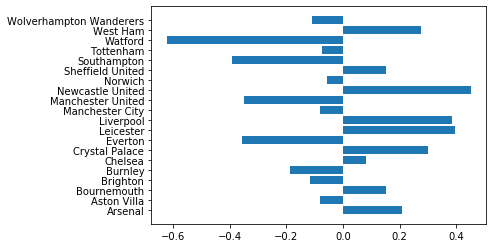

In [81]:
plt.barh(epl_teams.index, epl_teams['performance_ratio'])

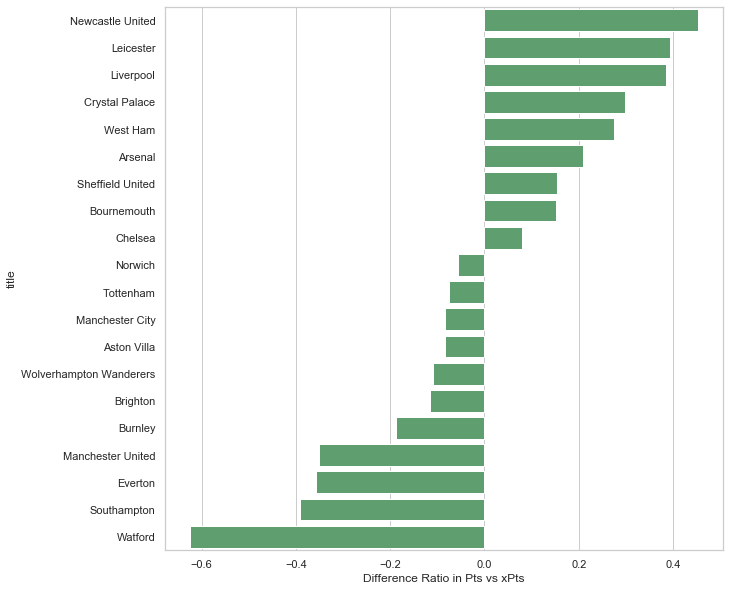

In [82]:
result = epl_teams.sort_values('performance_ratio', ascending=False)
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='performance_ratio', y=result.index, data=result, color='g')
ax.set_xlabel('Difference Ratio in Pts vs xPts');

In [83]:
epl_teams['xGpg'] = epl_teams['xG']/epl_teams['played']
epl_teams['xGApg'] = epl_teams['xGA']/epl_teams['played']
epl_teams['npxGpg'] = epl_teams['npxG']/epl_teams['played']
epl_teams['npxGApg'] = epl_teams['npxGA']/epl_teams['played']

In [84]:
epl_teams

,played,wins,draws,losses,scored,conceded,GD,xG,xGA,xGD,npxG,npxGA,npxGD,pts,xpts,performance_ratio,xGpg,xGApg,npxGpg,npxGApg
title,,,,,,,,,,,,,,,,,,,,
Arsenal,10,4,4,2,15,14,1,14.181327,15.555280,-1.373953,13.420167,12.510600,0.909567,16,13.2369,0.208742,1.418133,1.555528,1.342017,1.251060
Aston Villa,10,3,2,5,15,16,-1,15.109836,17.967829,-2.857993,14.195686,16.445504,-2.249818,11,11.9977,-0.083158,1.510984,1.796783,1.419569,1.644550
Bournemouth,10,3,4,3,13,13,0,12.708703,15.916496,-3.207793,11.947538,15.155326,-3.207788,13,11.2927,0.151186,1.270870,1.591650,1.194754,1.515533
Brighton,10,3,3,4,12,14,-2,13.711305,16.261520,-2.550215,12.950138,15.500350,-2.550212,12,13.5765,-0.116120,1.371131,1.626152,1.295014,1.550035
Burnley,10,3,3,4,14,15,-1,13.139477,11.306215,1.833262,13.139477,10.545045,2.594432,12,14.7872,-0.188487,1.313948,1.130622,1.313948,1.054504
Chelsea,10,6,2,2,23,16,7,20.528341,12.290236,8.238105,19.767171,11.529076,8.238095,20,18.5239,0.079686,2.052834,1.229024,1.976717,1.152908
Crystal Palace,10,4,3,3,10,12,-2,11.035489,15.925769,-4.890280,8.751979,15.164599,-6.412620,15,11.5470,0.299039,1.103549,1.592577,0.875198,1.516460
Everton,10,3,1,6,10,16,-6,14.515673,12.104471,2.411202,14.515673,11.343304,3.172369,10,15.5529,-0.357033,1.451567,1.210447,1.451567,1.134330
Leicester,10,6,2,2,25,8,17,13.313051,11.741651,1.571400,12.551891,10.219308,2.332583,20,14.3431,0.394399,1.331305,1.174165,1.255189,1.021931


In [85]:
forwards = players_us[players_us['position'].str.startswith('F')]

In [86]:
forwards

,id,player_name,games,goals,assists,key_passes,npg,npxG,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
0,755,Jamie Vardy,10,9,1,5,8,3.520233,F,0,20,Leicester,900,0.768060,4.281402,0.250875,4.539169,1
1,619,Sergio Agüero,9,8,2,11,6,5.267427,F S,0,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234,0
2,702,Tammy Abraham,10,8,1,10,8,5.650421,F S,0,31,Chelsea,748,1.532278,5.650421,0.530921,7.281866,2
3,318,Pierre-Emerick Aubameyang,10,7,0,8,7,4.599651,F M,0,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725,2
4,618,Raheem Sterling,9,7,1,19,7,6.653559,F M,0,33,Manchester City,797,3.895322,6.653559,4.180783,13.558886,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,7322,Bukayo Saka,5,0,1,6,0,0.645133,F M S,0,4,Arsenal,332,0.980876,0.645133,1.977158,3.028972,1
379,7420,Miguel Almirón,10,0,0,5,0,1.468156,F M,0,14,Newcastle United,833,0.173888,1.468156,0.808712,2.304973,2
389,7700,Che Adams,7,0,0,6,0,2.568231,F S,0,13,Southampton,469,0.826058,2.568231,0.345832,2.649224,0
398,7711,David McGoldrick,7,0,0,1,0,3.211859,F S,0,13,Sheffield United,487,0.079588,3.211859,0.407735,2.496554,1


In [87]:
fw = forwards[forwards['player_name'].isin(['Jamie Vardy', 'Sergio Agüero', 'Pierre-Emerick Aubameyang', 'Harry Kane', 'Callum Wilson', 'Roberto Firmino'])]

In [88]:
fw

,id,player_name,games,goals,assists,key_passes,npg,npxG,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards
0,755,Jamie Vardy,10,9,1,5,8,3.520233,F,0,20,Leicester,900,0.768060,4.281402,0.250875,4.539169,1
1,619,Sergio Agüero,9,8,2,11,6,5.267427,F S,0,30,Manchester City,569,2.011098,6.789728,1.886158,8.149234,0
3,318,Pierre-Emerick Aubameyang,10,7,0,8,7,4.599651,F M,0,28,Arsenal,900,0.846863,4.599651,1.839827,5.567725,2
5,647,Harry Kane,10,6,1,7,5,3.615927,F,0,28,Tottenham,897,0.812441,4.377096,1.114527,5.502408,0
7,468,Callum Wilson,10,5,0,13,5,4.509874,F,0,16,Bournemouth,872,1.351148,4.509874,0.222314,3.848685,2
21,482,Roberto Firmino,10,3,3,12,3,4.577433,F S,0,32,Liverpool,845,3.043869,4.577433,1.878708,8.637666,0


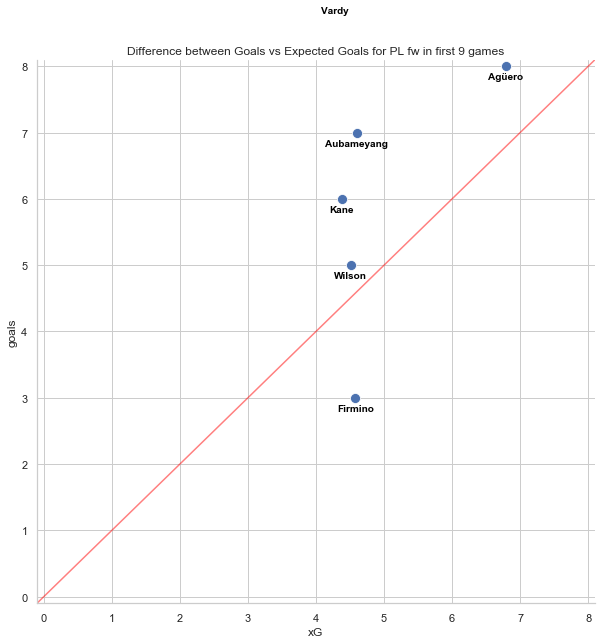

In [89]:
x = np.linspace(-0.1,8.1,100)
y = x
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(-0.1,8.1)
ax.set_ylim(-0.1,8.1)
sns.set_style('white')
sns.set_style('ticks')
sns.lineplot(x=x,y=y, color='red', alpha=0.5)
sns.scatterplot(x='xG', y='goals', data=fw, s=100)
plt.title('Difference between Goals vs Expected Goals for PL fw in first 9 games')
sns.despine()
for line in range(fw.shape[0]):
    if len(fw.iloc[line]['player_name'].split(' ')) == 2:
        plt.text(fw.iloc[line]['xG'], fw.iloc[line]['goals']-0.2, fw.iloc[line]['player_name'].split(' ')[1],
                 horizontalalignment='center', size='small', color='black', weight='semibold'),
    else:
        plt.text(fw.iloc[line]['xG'], fw.iloc[line]['goals'], fw.iloc[line]['player_name'], horizontalalignment='center', 
                 size='small', color='black', weight='semibold')

In [90]:
_1819 = pd.read_json('C:\\Users\\ryan\\players_18_19.json', lines=True)

In [91]:
_1819 

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,318,Pierre-Emerick Aubameyang,36,2740,22,23.549967,5,4.989847,94,33,0,0,F M S,Arsenal,18,19.744122,26.582426,6.483643
1,838,Sadio Mané,36,3100,22,16.762808,1,5.123735,87,45,2,0,F M S,Liverpool,22,16.762808,28.401346,8.485078
2,1250,Mohamed Salah,38,3274,22,21.792450,8,10.468590,137,68,1,0,F S,Liverpool,19,19.508944,31.780298,7.865945
3,619,Sergio Agüero,33,2515,21,19.949146,8,5.229243,118,34,3,0,F S,Manchester City,19,18.426809,28.700220,8.100998
4,755,Jamie Vardy,34,2740,18,19.115976,4,5.137330,79,32,3,1,F S,Leicester,14,15.310131,20.782562,1.905693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,7459,Will Norris,1,1,0,0.000000,0,0.000000,0,0,0,0,S,Wolverhampton Wanderers,0,0.000000,0.000000,0.000000
501,7487,Aaron Rowe,2,68,0,0.000000,0,0.000000,0,0,0,0,M S,Huddersfield,0,0.000000,0.022514,0.022514
502,7490,Mason Greenwood,3,111,0,0.797363,0,0.072345,7,3,0,0,F S,Manchester United,0,0.797363,1.019256,0.686998
503,7546,Harvey Elliott,2,16,0,0.056498,0,0.000000,1,0,0,0,S,Fulham,0,0.056498,0.096279,0.039781


In [92]:
_1819 = _1819[_1819['player_name'].isin(list(fw['player_name']))]

In [93]:
_1718 = pd.read_json('c:\\users\\ryan\\players_17_18.json', lines=True)

In [94]:
_1718 = _1718[_1718['player_name'].isin(list(fw['player_name']))]

In [95]:
_1718

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
1,647,Harry Kane,37,3094,30,26.859891,2,3.820441,183,34,5,0,F S,Tottenham,28,24.576384,28.515266,7.961634
2,619,Sergio Agüero,25,1985,21,18.568618,6,6.533230,95,39,2,0,F S,Manchester City,17,15.523943,23.707815,7.512719
3,755,Jamie Vardy,37,3269,20,15.266967,1,3.630826,70,33,3,0,F,Leicester,15,10.699991,15.584634,1.977742
6,482,Roberto Firmino,37,2814,15,10.763707,7,7.678425,84,56,1,0,F M S,Liverpool,14,10.002539,27.837452,12.625403
15,318,Pierre-Emerick Aubameyang,13,1056,10,9.174378,4,1.264148,31,13,0,0,F S,Arsenal,9,7.652040,10.671040,2.366456
31,468,Callum Wilson,28,2007,8,7.619610,2,1.552441,54,18,0,0,F S,Bournemouth,8,7.619610,9.413971,2.697104


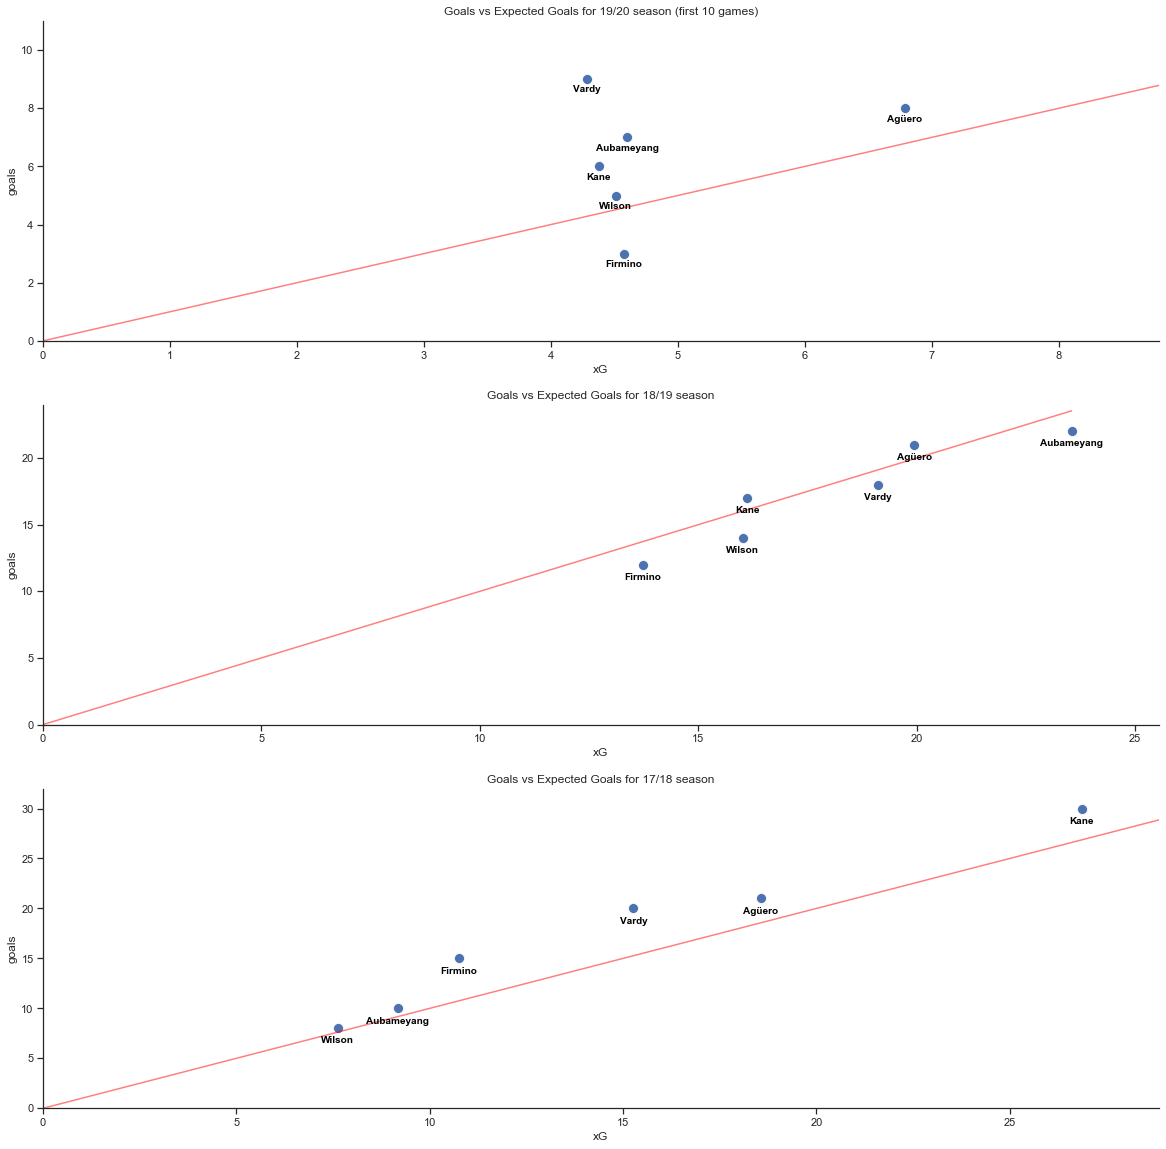

In [96]:
fig, ax = plt.subplots(3, figsize=(20,20))
dfs = [fw, _1819, _1718]
for index, df in enumerate(dfs):
    ax[index].set_xlim(0,max(df['xG'])+2)
    ax[index].set_ylim(0,max(df['goals'])+2)
    sns.set_style('white')
    sns.set_style('ticks')
    sns.lineplot(x=[0,max(max(df['goals']), max(df['xG']))], y=[0,max(max(df['goals']), max(df['xG']))], 
                 data=df, color='red', alpha=0.5, ax=ax[index])
    sns.scatterplot(x='xG', y='goals', data=df, s=100, ax=ax[index])
    sns.despine()
    for line in range(df.shape[0]):
        if len(df.iloc[line]['player_name'].split(' ')) == 2:
            ax[index].text(df.iloc[line]['xG'], df.iloc[line]['goals']-0.05*max(df['goals']), df.iloc[line]['player_name'].split(' ')[1],
                           horizontalalignment='center', size='small', color='black', weight='semibold'),
        else:
            ax[index].text(df.iloc[line]['xG'], df.iloc[line]['goals']-0.05*max(df['goals']), df.iloc[line]['player_name'],
                           horizontalalignment='center', size='small', color='black', weight='semibold')   

ax[0].set_title('Goals vs Expected Goals for 19/20 season (first 10 games)')
ax[1].set_title('Goals vs Expected Goals for 18/19 season')
ax[2].set_title('Goals vs Expected Goals for 17/18 season');

In [97]:
_1819

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,318,Pierre-Emerick Aubameyang,36,2740,22,23.549967,5,4.989847,94,33,0,0,F M S,Arsenal,18,19.744122,26.582426,6.483643
3,619,Sergio Agüero,33,2515,21,19.949146,8,5.229243,118,34,3,0,F S,Manchester City,19,18.426809,28.700220,8.100998
4,755,Jamie Vardy,34,2740,18,19.115976,4,5.137330,79,32,3,1,F S,Leicester,14,15.310131,20.782562,1.905693
6,647,Harry Kane,28,2437,17,16.122394,4,4.562663,102,30,5,0,F S,Tottenham,13,13.077756,18.838231,4.841164
8,468,Callum Wilson,30,2548,14,16.016501,9,5.955955,65,31,3,0,F S,Bournemouth,13,14.494163,21.330359,5.061332
17,482,Roberto Firmino,34,2631,12,13.737690,6,6.344290,75,43,0,0,F M S,Liverpool,11,12.976521,24.345639,9.149718


In [98]:
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_h,team_h_difficulty,team_h_score,team_a,team_a_difficulty,team_a_score
0,1059881,NaN,False,False,180,NaN,0,False,NaN,West Ham,4,NaN,10,3,NaN
1,1059702,1.0,True,True,1,2019-08-09T19:00:00Z,90,False,True,Liverpool,2,4.0,14,5,1.0
2,1059709,1.0,True,True,8,2019-08-10T11:30:00Z,90,False,True,West Ham,4,0.0,11,3,5.0
3,1059703,1.0,True,True,2,2019-08-10T14:00:00Z,90,False,True,Bournemouth,2,1.0,15,3,1.0
4,1059704,1.0,True,True,3,2019-08-10T14:00:00Z,90,False,True,Burnley,2,3.0,16,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1060077,38.0,False,False,376,2020-05-17T14:00:00Z,0,False,False,Leicester,4,NaN,12,4,NaN
376,1060078,38.0,False,False,377,2020-05-17T14:00:00Z,0,False,False,Manchester City,2,NaN,14,5,NaN
377,1060079,38.0,False,False,378,2020-05-17T14:00:00Z,0,False,False,Newcastle United,4,NaN,10,2,NaN
378,1060080,38.0,False,False,379,2020-05-17T14:00:00Z,0,False,False,Southampton,2,NaN,15,2,NaN


In [99]:
fixtures['team_a'].replace({i:teams_ser[i] for i in range(1,21)},inplace=True)

In [100]:
fixtures['kickoff_time'] = pd.to_datetime(fixtures['kickoff_time'])

In [101]:
fixtures['kickoff_time'] = fixtures['kickoff_time'].dt.date

In [102]:
fixtures.rename(columns= {'kickoff_time': 'kickoff_date'}, inplace=True)

In [103]:
fixtures = fixtures[['code', 'event',  'id',
       'kickoff_date',
       'team_h', 'team_h_difficulty', 'team_h_score', 'team_a',
       'team_a_difficulty', 'team_a_score']]

In [104]:
fixtures_gw_11 = fixtures[(fixtures['kickoff_date'] == pd.to_datetime('2019-11-02')) | 
                          (fixtures['kickoff_date'] == pd.to_datetime('2019-11-03'))]

In [105]:
fixtures_gw_11

,code,event,id,kickoff_date,team_h,team_h_difficulty,team_h_score,team_a,team_a_difficulty,team_a_score
101,1059802,11.0,103,2019-11-02,Bournemouth,4,NaN,Manchester United,3,NaN
102,1059803,11.0,101,2019-11-02,Arsenal,2,NaN,Wolverhampton Wanderers,4,NaN
103,1059804,11.0,102,2019-11-02,Aston Villa,4,NaN,Liverpool,2,NaN
104,1059805,11.0,104,2019-11-02,Brighton,2,NaN,Norwich,2,NaN
105,1059808,11.0,107,2019-11-02,Manchester City,2,NaN,Southampton,5,NaN
106,1059809,11.0,108,2019-11-02,Sheffield United,2,NaN,Burnley,2,NaN
107,1059811,11.0,110,2019-11-02,West Ham,2,NaN,Newcastle United,3,NaN
108,1059810,11.0,109,2019-11-02,Watford,4,NaN,Chelsea,2,NaN
109,1059806,11.0,105,2019-11-03,Crystal Palace,3,NaN,Leicester,2,NaN
110,1059807,11.0,106,2019-11-03,Everton,4,NaN,Tottenham,3,NaN


In [106]:
epl_teams.rename(columns={'title':'team'}, inplace=True)

In [107]:
fixtures_gw_11 = pd.merge(fixtures_gw_11, epl_teams, left_on='team_h', right_on='team')

KeyError: 'team'

In [ ]:
fixtures_gw_11 = fixtures_gw_11[['code', 'event', 'id', 'kickoff_date', 'team_h', 'team_h_difficulty',
        'team_a', 'team_a_difficulty', 'xGpg', 'xGApg']]

In [ ]:
fixtures_gw_11.rename(columns={'xGpg': 'xGpg_h', 'xGApg': 'xGApg_h'}, inplace=True)

In [ ]:
fixtures_gw_11 = pd.merge(fixtures_gw_11, epl_teams, left_on = 'team_a', right_on='team')

In [ ]:
fixtures_gw_11.rename(columns={'xGpg': 'xGpg_a', 'xGApg': 'xGApg_a'}, inplace=True)

In [ ]:
fixtures_gw_11 = fixtures_gw_11[['code', 'event', 'id', 'kickoff_date', 'team_h', 'team_h_difficulty',
       'team_a', 'team_a_difficulty', 'xGpg_h', 'xGApg_h',
       'xGpg_a', 'xGApg_a']]

In [ ]:
fixtures_gw_11

In [ ]:
fixtures_18_19 = pd.read_csv('C:\\Users\\Ryan\\Fantasy-Premier-League-master\\Fantasy-Premier-League-master\\data\\2018-19\\fixtures.csv')

In [ ]:
fixtures_18_19 = fixtures_18_19[['code','event',
       'event_day','id',
       'minutes',
       'team_a', 'team_a_difficulty', 'team_a_score',
       'team_h', 'team_h_difficulty', 'team_h_score']]

In [ ]:
fixtures_18_19

In [ ]:
(fixtures_18_19['team_h_score'].sum() + fixtures_18_19['team_a_score'].sum()) / (380*2)

In [ ]:
fixtures_18_19['team_h_score'].sum()/380

In [ ]:
fixtures_18_19['team_a_score'].sum() / 380

In [ ]:
home_adj = np.round((fixtures_18_19['team_h_score'].sum()/380)/((fixtures_18_19['team_h_score'].sum() + fixtures_18_19['team_a_score'].sum()) / (380*2)), 4)

In [ ]:
away_adj = np.round((fixtures_18_19['team_a_score'].sum()/380)/((fixtures_18_19['team_h_score'].sum() + fixtures_18_19['team_a_score'].sum()) / (380*2)), 4)

In [ ]:
home_adj, away_adj

In [ ]:
fixtures_gw_11

In [ ]:
xGpg_avg = epl_teams['xGpg'].mean()

In [ ]:
fixtures_gw_11['xG_adj_h'] = ((fixtures_gw_11['xGpg_h']*fixtures_gw_11['xGApg_a'])/xGpg_avg)*home_adj

In [ ]:
fixtures_gw_11['xG_adj_a'] = ((fixtures_gw_11['xGpg_a']*fixtures_gw_11['xGApg_h'])/xGpg_avg)*away_adj

In [ ]:
fixtures_gw_11

In [ ]:
scores_gw_11 = fixtures_gw_11[['team_h', 'team_a','xG_adj_h', 'xG_adj_a']]

In [ ]:
scores_gw_11